# Notebook #2: Investigation on Item Popularity

Recommender systems are **bridging users and relevant products**, services and peers on the Web. By leveraging past behavioural data, such automated systems aim to learn patterns behind users’ preferences and predict the future interests of users. Notable examples are integrated into platforms that cover different contexts, including e-commerce (e.g., Amazon, eBay), entertainment (e.g., YouTube, Netflix), and education (e.g., edX, Udemy). The success of these platforms strongly depends on the effectiveness of their recommender system.

The increasing adoption of recommender systems in online platforms has spurred investigations on **issues of bias** in their internal mechanisms. One aspect that has received attention is the recommender systems’ tendency of emphasizing a “rich-get-richer” effect in favor of **popular items**. Such a phenomenon leads to a loop where recommender systems trained on data non-uniformly distributed across items tend to suggest popular items more than niche items, even when the latter would be of interest. Thus, **popular items gain higher visibility and become more likely to be selected**. The awareness of this type of bias might even lead providers to bribe users, so that they rate or increase the ratings given to their items, thus allowing these items to get more visibility. Under this repeated loop, **the training data becomes imbalanced towards a tiny set of items** more and more, as a result of a strong popularity bias.

Recommender systems that **suggest the most popular items have been proved to achieve competitive accuracy**, compared with advanced recommendation techniques. However, the literature has acknowledged that other aspects beyond the accuracy of the recommender system, such as whether the suggested items are novel and cover well the catalog, can make a positive impact on the overall recommendation quality. Unfortunately, **a bias against item popularity may emphasize the occurrence of filter bubbles**, thus hampering users’ interest and several beyond-accuracy aspects. Trading such aspects for item popularity might likely not be accepted by the users who finally receive the recommendations. Therefore, mitigating the impact of a popularity bias can help to meet **a better trade-off between accuracy and beyond-accuracy objectives**, with a clear benefit for the recommendation quality.

Existing frameworks and techniques for mitigating a popularity bias are often based on evaluation metrics that do not account for users’ preferences, being assessed only on the level of popularity of items in a recommended list. However, **controlling popularity cannot be a final objective concept**, as it strongly depends on users’ preferences and on how data has been collected. It follows that popularity metrics and bias mitigation need to account for the users’ tastes and the visibility given to items thanks to recommendations, creating a bridge between these perspectives by means of beyond-accuracy objectives.

## Setup the working environment for this notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/My Drive/umap2020/notebooks

In [1]:
import sys 
import os

sys.path.append(os.path.join('..'))

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from helpers.utils import *
from helpers.train_test_splitter import *
from models.pairwise import PairWise

In [5]:
data_path = '../data/'

## Step 1: Load data

First, we will load the **Movielens 1M** dataset, which has been pre-arranged in order to comply with the following structure: user_id, item_id, rating, timestamp, type (label for the item category), and type_id (unique id of the item category). For the sake of tutorial easiness, we assume here that each item is randomly assigned to one of its categories in the original dataset.

In [6]:
dataset = 'ml1m'
smode = 'utime'
user_field = 'user_id'
item_field = 'item_id'
rating_field = 'rating'
time_field = 'timestamp'
type_field = 'type_id'

In [7]:
data =  pd.read_csv('../data/outputs/splits/' + dataset + '_' + smode + '.csv', encoding='utf8')

We assume that the number of ratings is a proxy of the popularity of the item. We calculate the popularity of each item and we sort items in a dataframe by decreasing popularity. 

In [8]:
item_pop = data.groupby([item_field]).count().sort_values(user_field, ascending=False)[user_field]

In [9]:
item_pop

item_id
2651    3428
253     2991
1106    2990
1120    2883
466     2672
        ... 
3013       1
725        1
607        1
2367       1
3064       1
Name: user_id, Length: 3706, dtype: int64

For the sake of easiness, we conduct our study focusing on two sets of items: most popular items and less popular items. To this end, we will consider the most popular 800 items in the first set, while the remaining items are included in the second set. Several ways to split items in these two sets arefound in literature (e.g., most popular items that receive the 80% of the overall ratings).    

In [10]:
head_tail_split = 808 # Magic number
head_tail_items = np.array(item_pop[:head_tail_split].index)
long_tail_items = np.array(item_pop[head_tail_split:].index)

In [11]:
print('Head Tail', compute_gini(item_pop[:head_tail_split]))
print('Long Tail', compute_gini(item_pop[head_tail_split:]))

Head Tail 0.2746823308765163
Long Tail 0.5250342105989467


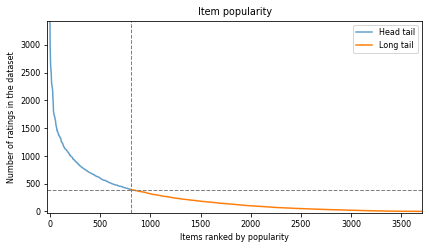

In [12]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(6, 3.5))

plt.title(r'Item popularity')
plt.xlabel('Items ranked by popularity')
plt.ylabel('Number of ratings in the dataset')
plt.plot(range(head_tail_split), item_pop.values[:head_tail_split], alpha=0.7, label=r'Head tail')
plt.plot(range(head_tail_split, len(item_pop.index)), item_pop.values[head_tail_split:], label=r'Long tail')
plt.axhline(y=item_pop.values[head_tail_split], linestyle='--', lw=1, c='grey')
plt.axvline(x=head_tail_split, linestyle='--', lw=1, c='grey')
plt.xlim([-25, len(item_pop.index)])
plt.ylim([-25, item_pop.values[0]])
plt.legend()
plt.tight_layout()

Please note how the curve is skewed towards items with only few ratings. In our case, most popular items are those receving more than 450 ratings. In the rest of this study, we will investigate how recommendation algorithms treat items belonging to these sets. 

## Step 2: Analysis of the popularity of the recommended items

We will use the same cutoffs we have configured in the first notebook. 

In [13]:
cutoffs = np.array([5, 10, 20, 50, 100, 200])

In this notebook, we will first compare the characteristics of the items recommended by pairwise, pointwise, random and mostpop strategies. Later on, we will come back here to compare also the results of the mitigation procedures with those of the above recommendation algorithms.  

In [14]:
model_types = ['utime_pointwise', 'utime_pairwise', 'utime_random', 'utime_mostpop']

To speed up, we will load the metrics pre-computed in the first notebook. 

In [15]:
def load_metrics(model_types):
    metrics = {}
    for model_type in model_types:
        metrics[model_type] = load_obj(os.path.join(data_path, 'outputs/metrics/'+dataset+'_'+model_type+'_metrics.pkl'))
    return metrics

In [16]:
metrics = load_metrics(model_types)

First, we will compare the considered algorithms based on their recommendation effectiveness: precision, recall, and NDCG. 

In [17]:
def plot_effectiveness(metrics, cutoffs):
    plt.rcParams.update({'font.size': 16.5})
    plt.figure(figsize=(30, 7.5))

    plt.subplot(131)
    plt.title(r'Precision')
    plt.xlabel('Cutoff Value')
    plt.ylabel('Precision')
    for model_type in model_types:
        plt.plot(cutoffs, [np.mean(metrics[model_type]['precision'][k,:]) for k in range(len(cutoffs))], label=model_type)
    plt.xticks(cutoffs)
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(132)
    plt.title(r'Recall')
    plt.xlabel('Cutoff Value')
    plt.ylabel('Recall')
    for model_type in model_types:
        plt.plot(cutoffs, [np.mean(metrics[model_type]['recall'][k,:]) for k in range(len(cutoffs))], label=model_type)
    plt.xticks(cutoffs)
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(133)
    plt.title(r'NDCG')
    plt.xlabel('Cutoff Value')
    plt.ylabel('NDCG')
    for model_type in model_types:
        plt.plot(cutoffs, [np.mean(metrics[model_type]['ndcg'][k,:]) for k in range(len(cutoffs))], label=model_type)
    plt.xticks(cutoffs)
    plt.legend()
    plt.grid(axis='y')

    plt.tight_layout()

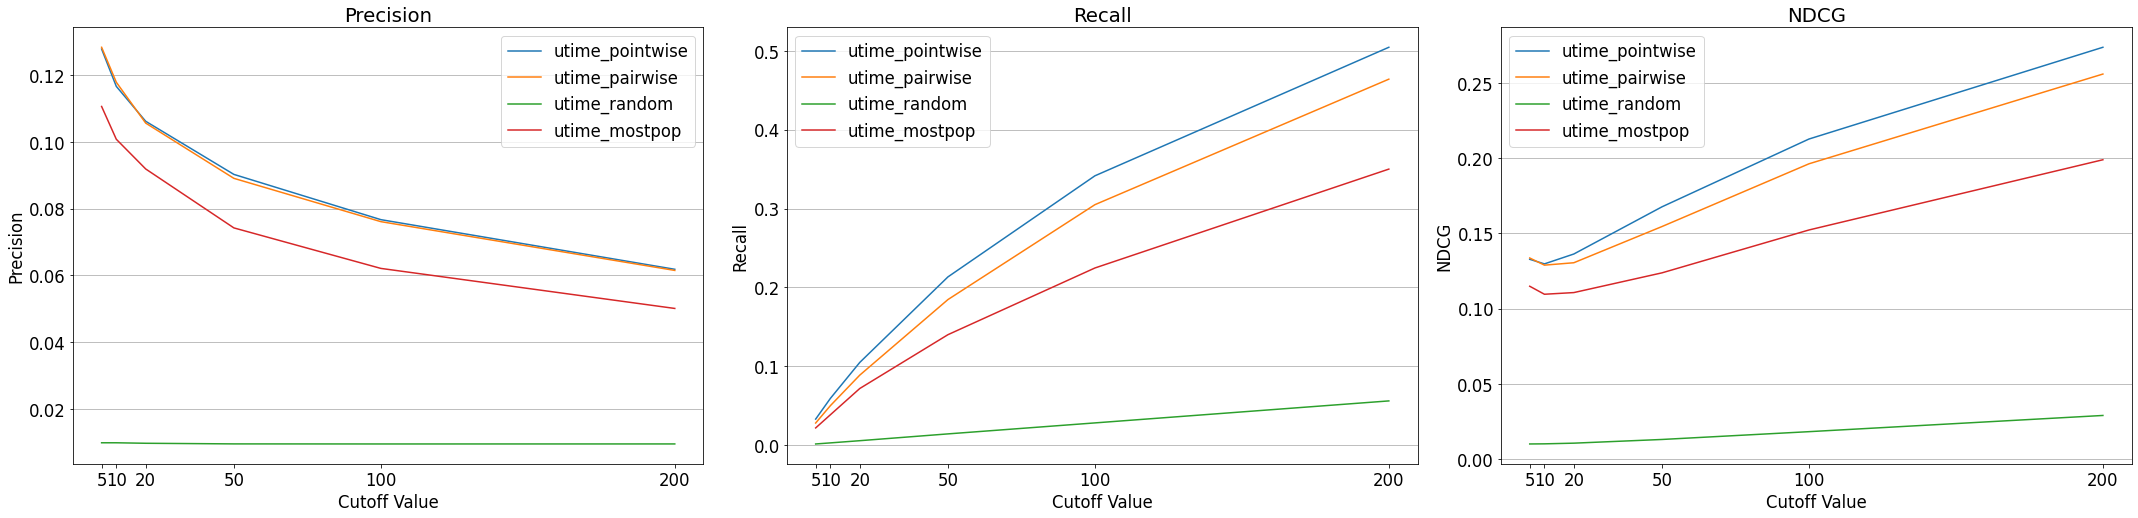

In [18]:
plot_effectiveness(metrics, cutoffs)

Please note that pairwise and mostpop algorithms have a really similar behavior for all the considered metrics. Nove, we move our attention to the popularity of the recommended items and the coverage of the items we marked as "less popular".  

In [19]:
def plot_item_related_metrics(metrics, cutoffs):
    plt.rcParams.update({'font.size': 16.5})
    plt.figure(figsize=(30, 7.5))

    plt.subplot(131)
    plt.title(r'Average Popularity of Items')
    plt.xlabel('Cutoff Value')
    plt.ylabel('APT')
    for model_type in model_types:
        plt.plot(cutoffs, [np.mean(metrics[model_type]['mean_popularity'][k,:]) for k in range(len(cutoffs))], label=model_type)
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(132)
    plt.title(r'Average Percentage of Less Popular Items')
    plt.xlabel('Cutoff Value')
    plt.ylabel('APLT')
    for model_type in model_types:
        plt.plot(cutoffs, [np.sum(metrics[model_type]['item_coverage'][k,long_tail_items]) / np.sum(metrics[model_type]['item_coverage'][k,:]) for k in range(len(cutoffs))], label=model_type)
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(133)
    plt.title(r'Item Coverage')
    plt.xlabel('Cutoff Value')
    plt.ylabel('Item Coverage')
    for i, model_type in enumerate(model_types):
        plt.plot(cutoffs, [len([1 for m in metrics[model_type]['item_coverage'][k,head_tail_items] if m > 0]) / len(head_tail_items) for k in range(len(cutoffs))], color='C'+str(i), linestyle='-', label='pop head of ' + model_type)
        plt.plot(cutoffs, [len([1 for m in metrics[model_type]['item_coverage'][k,long_tail_items] if m > 0]) / len(long_tail_items) for k in range(len(cutoffs))], color='C'+str(i), linestyle=':', label='pop tail of ' + model_type)
    plt.legend()
    plt.grid(axis='y')

    plt.tight_layout()

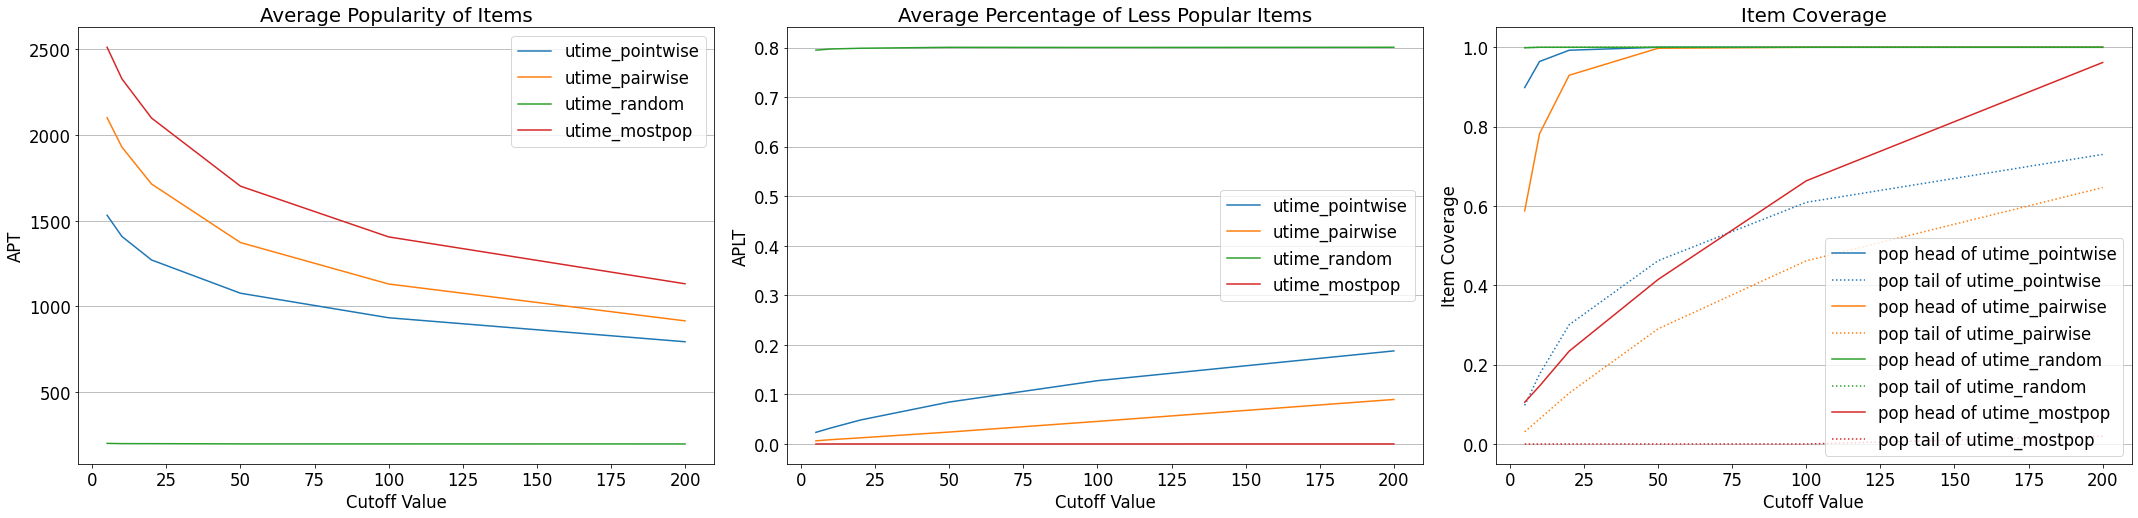

In [20]:
plot_item_related_metrics(metrics, cutoffs)

These figures show us that the average popularity of items recommended by the pairwise algorithm is really high and not so far from the one of items recommended by mostpop. This observation is also confirmed by the coverage of items from the "less popular" set. For small cutoffs, pairwise and mostpop recommened only a tiny fraction of the less popular items. 

## Step 3: Promote less popular items via in-processing

We investigate how a recommender system can generate recommendations less biased against popularity. To this end, we propose a mitigation procedure that aims at minimizing both (i) the loss function targeted by the considered recommendation algorithm, and (ii) the biased correlation between the predicted relevance and the popularity of the observed item. We show a didactic version of the correlation-based regularization proposed by Boratto et al. (2021).

- Boratto, Ludovico, Gianni Fenu, and Mirko Marras. Connecting user and item perspectives in popularity debiasing for collaborative recommendation, Information Processing & Management, Volume 58, Issue 1, 2021, 102387, ISSN 0306-4573, https://doi.org/10.1016/j.ipm.2020.102387.

We run again the recommendation pipeline, starting by the train-test split. 

In [21]:
smode = 'utime'
train_ratio = 0.80        
min_train_samples = 8
min_test_samples = 2
min_time = None
max_time = None
step_time = 1000

In [22]:
if smode == 'uftime':
    traintest = fixed_timestamp(data, min_train_samples, min_test_samples, min_time, max_time, step_time, user_field, item_field, time_field, rating_field)
elif smode == 'utime':
    traintest = user_timestamp(data, train_ratio, min_train_samples+min_test_samples, user_field, item_field, time_field)
elif smode == 'urandom':
    traintest = user_random(data, train_ratio, min_train_samples+min_test_samples, user_field, item_field)

> Parsing user 6040 of 6040


In [23]:
train = traintest[traintest['set']=='train'].copy()
test = traintest[traintest['set']=='test'].copy()

In [24]:
users = list(np.unique(traintest[user_field].values))
items = list(np.unique(traintest[item_field].values))

In [25]:
items_metadata = traintest.drop_duplicates(subset=['item_id'], keep='first')
category_per_item = items_metadata[type_field].values

In [26]:
gender_item_association = pd.read_csv(os.path.join(data_path, 'datasets', 'ml1m-dir-gender.csv')) 
gender_maps = {i:g for i, g in zip(gender_item_association['item_id'], gender_item_association['gender_1'])}
item_maps = {i1:i2 for i1, i2 in zip(traintest['item_id'].unique(), traintest['item_id_original'].unique())}
item_group = [(1 if item_maps[i] in gender_maps and gender_maps[item_maps[i]] == 0 else 0) for i in range(len(items))]

We use a supporting function to run a regularized version of the pairwise recommender model, where *rweight* represents the weights given to the regularization during the learning phase. The higher the weight is, the more the correlation between popularity and predicted margin is reduced. 

In [27]:
def run_reg_pairwise_model(rweight=0.0, no_epochs=None):
    model_id = smode + '_' + str(int(rweight*100)) + '_' + 'pairwise'
    
    print('\n***Running experimental pipeline for model with id', model_id)
    
    model = PairWise(users, items, train, test, category_per_item, item_field, user_field, rating_field)
    model.train(no_epochs=no_epochs, rweight=rweight) if no_epochs else model.train(rweight=rweight) 
    model.predict()
    scores = model.get_predictions()
    save_obj(scores, os.path.join(data_path, 'outputs/predictions/' + dataset + '_' + model_id + '_scores.pkl'))
    
    model.test(item_group=item_group, cutoffs=cutoffs)
    
    metrics = model.get_metrics()
    save_obj(metrics, os.path.join(data_path, 'outputs/metrics/' + dataset + '_' + model_id + '_metrics.pkl'))
    
    print('\nFinal evaluation metrics:')
    model.show_metrics(index_k=int(np.where(cutoffs == 10)[0]))

We have two trials with the new regularization. The results will be then compared against the ones achieved by the base pairwise recommender model. 

In [ ]:
rweights = [0.01, 0.05] 

for r in rweights:
    run_reg_pairwise_model(rweight=r, no_epochs=5)


***Running experimental pipeline for model with id utime_1_pairwise
Initializing user, item, and categories lists
Initializing observed, unobserved, and predicted relevance scores
Initializing item popularity lists
Initializing category per item
Initializing category preference per user
Initializing metrics
Generating training instances of type pair
Created training instances randomly
Computing instances for interaction 800000 / 803798 of type pair
Performing training - Epochs 5 Batch Size 1024 Learning Rate 0.001 Factors 10 Negatives 10 Mode pair
Train on 7957600 samples
7957600/7957600 [==============================] - 42s 5us/sample - loss: 0.1934 - acc_loss: 0.1932 - corr_loss: 0.2169
Validation accuracy: 0.8730529982582732 (Sample 80379 of 80380)
Train on 7957600 samples
Epoch 2/2
7957600/7957600 [==============================] - 42s 5us/sample - loss: 0.1221 - acc_loss: 0.1217 - corr_loss: 0.1586
Train on 7957600 samples
Epoch 3/3
7957600/7957600 [=============================

To show the results and compare them against each other, we load the pre-computed metrics and use the supporting plot functions.  

In [ ]:
model_types = ['utime_pairwise', 'utime_1_pairwise', 'utime_5_pairwise', 'utime_10_pairwise']

In [ ]:
metrics = load_metrics(model_types)

In [ ]:
plot_effectiveness(metrics, cutoffs)

In [ ]:
plot_item_related_metrics(metrics, cutoffs)

## Step 3: Promote less popular items via post-processing

In this part, we will show how to setup and perform a post-processing mitigation approach. We show a didactic version of the xQuad algorithm adaptation proposed by Adbollahpouri et al. (2018). Intuitively, they provide a function with two terms: the first term incorporates ranking accuracy while the second term promotes diversity between two different categories of items (i.e. short head and long tail). A weight controls how strongly controlling popularity bias is.

- Himan Abdollahpouri, Robin Burke, Bamshad Mobasher: Managing Popularity Bias in Recommender Systems with Personalized Re-Ranking. FLAIRS Conference 2019: 413-418. https://aaai.org/ocs/index.php/FLAIRS/FLAIRS19/paper/view/18199

In [ ]:
traintest = pd.read_csv('../data/outputs/splits/' + dataset + '_' + smode + '.csv', encoding='utf8')

In [ ]:
train = traintest[traintest['set']=='train'].copy()
test = traintest[traintest['set']=='test'].copy()

In [ ]:
users = list(np.unique(traintest[user_field].values))
items = list(np.unique(traintest[item_field].values))

In [ ]:
items_metadata = traintest.drop_duplicates(subset=['item_id'], keep='first')
category_per_item = items_metadata[type_field].values

Now, we are ready to import and usethe re-ranking model mentioned above. 

In [ ]:
from models.ranker_xquad import RankerXQuad
model = RankerXQuad(users, items, train, test, category_per_item, item_field, user_field, rating_field)

In [ ]:
original_model_type = 'utime_pairwise' # This string identifies the recommendation algorithm where the re-ranking is applied
reranked_model_type = original_model_type + '_' + 'xquad' # This string is an identifier for models results in data/outputs

We initialize the model predictions with those of the original recommendation model, precomputed in the first notebook. 

In [ ]:
predictions = load_obj(os.path.join(data_path,'outputs/predictions/' + dataset + '_' + original_model_type + '_scores.pkl'))

In [ ]:
model.set_predictions(predictions)

Now, we can run the re-ranking process and save the positional relevance of items for users after re-ranking.  

In [ ]:
model.rerank(type='smooth', lmbda=0.4, k=10, rmax=100, head_tail_split=head_tail_split)

In [ ]:
predictions = model.get_predictions()

In [ ]:
save_obj(predictions, os.path.join(data_path, 'outputs/predictions/' + dataset + '_' + reranked_model_type + '_scores.pkl'))

Finally, we compute and show the metrics for the recommender systems obtained after re-ranking. 

In [ ]:
model.test(cutoffs)

In [ ]:
metrics = model.get_metrics()

In [ ]:
save_obj(metrics, os.path.join(data_path, 'outputs/metrics/' + dataset + '_' + reranked_model_type + '_metrics.h5'))

##### To speed up of process in this tutorial

This re-ranking takes several minutes. For this tutorial, please feel free to stop and load directly our pre-computed re-ranking predictions (2 MB).  

In [ ]:
!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':'1lAmSPd19F4WRfWz0TOdFcOzHUMieSJOX'}) 
downloaded.GetContentFile('../data/outputs/metrics/ml1m_utime_pairwise_xquad_metrics.pkl')

In [ ]:
model.set_metrics(load_obj('../data/outputs/metrics/ml1m_utime_pairwise_xquad_metrics.pkl'))

In [ ]:
model.show_metrics(index_k=int(np.where(cutoffs == 10)[0]))

Finally, we have obtained the metrics resulting from the considered strategy. Now, we come back to compare the results obtained with these strategy against the ones of the baseline recommendation algorithms. 

In [ ]:
model_types = ['utime_pointwise', 'utime_pairwise', 'utime_pairwise_xquad', 'utime_random', 'utime_mostpop']

In [ ]:
metrics = load_metrics(model_types)

In [ ]:
plot_effectiveness(metrics, np.array([5, 10]))

In [ ]:
plot_item_related_metrics(metrics, np.array([5, 10]))

## Follow-up: how to extend the toolbox with mitigation strategies

- Strategy at dataset level: just apply your mitigation strategy to the original csv of the dataset and swap it in our code. 
- Strategy at train instance level: just create another generator in helpers/instances_creator.py and use it in our code.
- Strategy at learning level: create a copy of the model you want to consider for your strategy (e.g., models/pairwise.py) and add your mitigation strategy. 
- Strategy at ranking level: create a copy of the ranker mentioned above (i.e., models/ranker_xquad) and use it as a basis for another re-ranking strategy.  